This script is meant to contain a bunch of timeseries diagrams that show how certain variables are changing over time. At the moment it is very messy due to some... experimentation with the best way to protry these time series given the disperse sampling time of the Wade and CTD data. Hopefully, we can acquire some moore data that will allow for the formation of more detailed timeseries. This notebook will allow for multiple years to e viewed easily. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import xarray as xr
import datetime as dt
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
years=[2009,2010]
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [3]:
display(Markdown('''## Years: '''+ str(years)))

## Years: [2009, 2010]

In [4]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

In [5]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData'
dictBot=dict()

for Y in years:
    with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictBot[Y]=pickle.load(hh)
        
data=pd.concat(dictBot.values(), ignore_index=True)

In [6]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

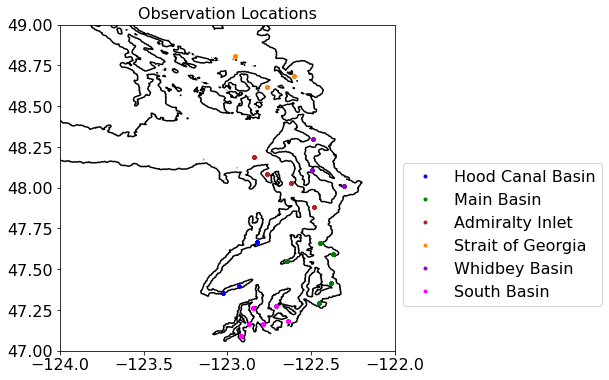

In [7]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15)

# When working with multiple years, a for loop is necessary to split things up by months. 
JFMd=dict()
Aprd=dict()
MJJAd=dict()
SONDd=dict()
for i in years:
    JFMd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,4,1)),:]
    Aprd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,5,1))&(data.dtUTC>dt.datetime(i,4,1)),:]
    MJJAd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,9,1))&(data.dtUTC>dt.datetime(i,5,1)),:]
    SONDd[i]=data.loc[iz&(data.dtUTC>dt.datetime(i,9,1)),:]
JFM=pd.concat(JFMd.values(), ignore_index=True)
Apr=pd.concat(Aprd.values(), ignore_index=True)
MJJA=pd.concat(MJJAd.values(), ignore_index=True)
SOND=pd.concat(SONDd.values(), ignore_index=True)

These two new dictionaries make it easier to call upon graphs for different years. 

In [8]:
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datyear=dict()
for ind, iyear in enumerate(data.dtUTC.dt.year.unique()):
    datyear[iyear] = data.loc[data.dtUTC.dt.year==iyear]
    
datyearreg=dict()
for iyear in datyear:
    datyearreg[iyear]=dict()
    for iregion in datyear[iyear].Basin.unique():
        datyearreg[iyear][iregion]=datyear[iyear].loc[datyear[iyear].Basin==iregion]

In [9]:
def byDepth(ax,obsvar,modvar,lims,byyear = False,year = 'NA'):
    if byyear == False:
        ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
        l=ax.legend(handles=ps)
    elif byyear == True:
        ps=et.varvarPlot(ax,datyear[year],obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
        l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims,year):
    ps=[]
    for ind, iregion in enumerate(data[data.dtUTC.dt.year==year].Basin.unique()):
        ax.plot(datyearreg[year][iregion]['Lon'], datyearreg[year][iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datyearreg[year][iregion],obsvar,modvar,
                        cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byStation(ax,obsvar,modvar,lims,region):
    ps=[]
    for ind, istation in enumerate(data[data['Basin'] == region].Station.unique()):
        ax.plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                    color = colors[ind], label=istation)
        ps0=et.varvarPlot(ax,datstat[istation],obsvar,modvar,
                            cols=(colors[ind],),lname=istation)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

In [10]:
def multi_timerror_graph(down,figsize,years,obsvar,modvar):
    fig,ax=plt.subplots(down,1,figsize=figsize)
    for d,Y in zip(range(down),years):
            m=ax[d].scatter(datyear[Y]['dtUTC'],datyear[Y][modvar]-datyear[Y][obsvar],s=8,cmap='gnuplot') 
            ax[d].set_xlabel(f'Date',fontsize=20)
            ax[d].set_ylabel(f'{obsvar} Error ($\mu$M)',fontsize=20)
            ax[d].set_title(str(Y), fontsize=22)
            yearsFmt = mdates.DateFormatter('%d %b')
            ax[d].xaxis.set_major_formatter(yearsFmt)
    plt.tight_layout()
    
def multi_meanerr_graph(down,figsize,years,obsvar,modvar):
    fig,ax=plt.subplots(down,1,figsize=figsize)
    for d,Y in zip(range(down),years):
            meanerr=datyear[Y].groupby(by='dtUTC').mean()
            m=ax[d].plot(datyear[Y]['dtUTC'].unique(),meanerr[modvar]-meanerr[obsvar],'c-') 
            ax[d].set_xlabel(f'Date',fontsize=20)
            ax[d].set_ylabel(f'{obsvar} Error ($\mu$M)',fontsize=20)
            ax[d].set_title(str(Y), fontsize=22)
            yearsFmt = mdates.DateFormatter('%d %b')
            ax[d].xaxis.set_major_formatter(yearsFmt)
    plt.tight_layout()

In [11]:
def multi_timese_graph(down,figsize,years,obsvar,modvar):
    fig,ax=plt.subplots(down,1,figsize=figsize)
    for d,Y in zip(range(down),years):
            #meanerr=datyear[Y].groupby(by='dtUTC').mean()
            #m=ax[d].plot(datyear[Y]['dtUTC'].unique(),meanerr[obsvar],'--',color='blue',alpha=0.2)
            #s=ax[d].plot(datyear[Y]['dtUTC'].unique(),meanerr[modvar],'--',color='red',alpha=0.2)
            m=ax[d].scatter(datyear[Y]['dtUTC'],datyear[Y][obsvar],color='blue',s=8,cmap='gnuplot',label='Observed')
            s=ax[d].scatter(datyear[Y]['dtUTC'],datyear[Y][modvar],color='red',s=8,cmap='gnuplot',label='Model')
            ax[d].legend(loc='upper right')
            ax[d].set_xlabel(f'Date',fontsize=20)
            ax[d].set_ylabel(f'{obsvar} ($\mu$M)',fontsize=20)
            ax[d].set_title(str(Y), fontsize=22)
            yearsFmt = mdates.DateFormatter('%d %b')
            ax[d].xaxis.set_major_formatter(yearsFmt)
    plt.tight_layout()

## Observed nitrate and model nitrate over time

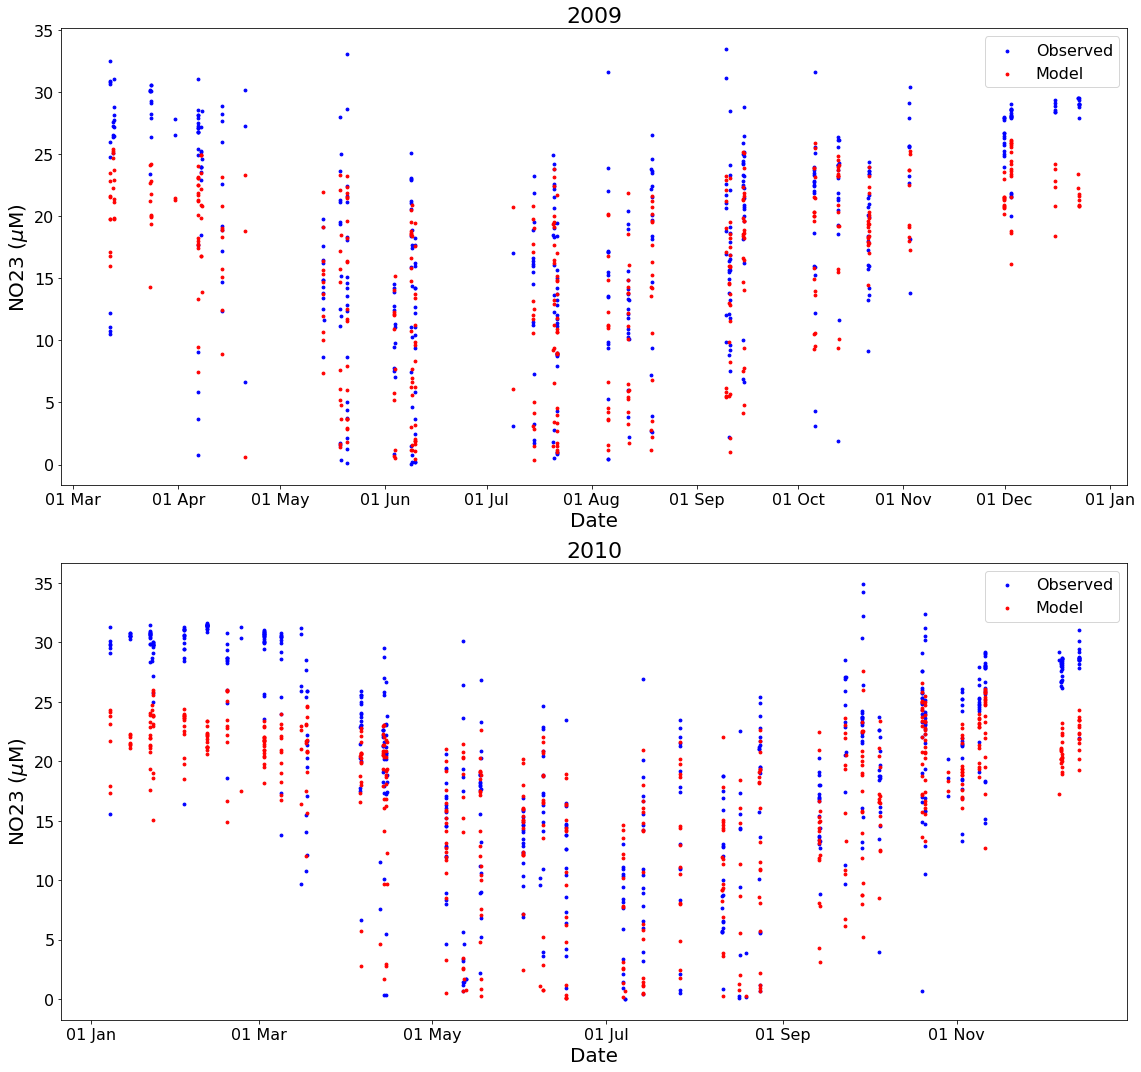

In [12]:
obsvar='NO23'
modvar='mod_nitrate'

multi_timese_graph(2,(16,15),years,obsvar,modvar)

## Observed silicate and model silicate over time

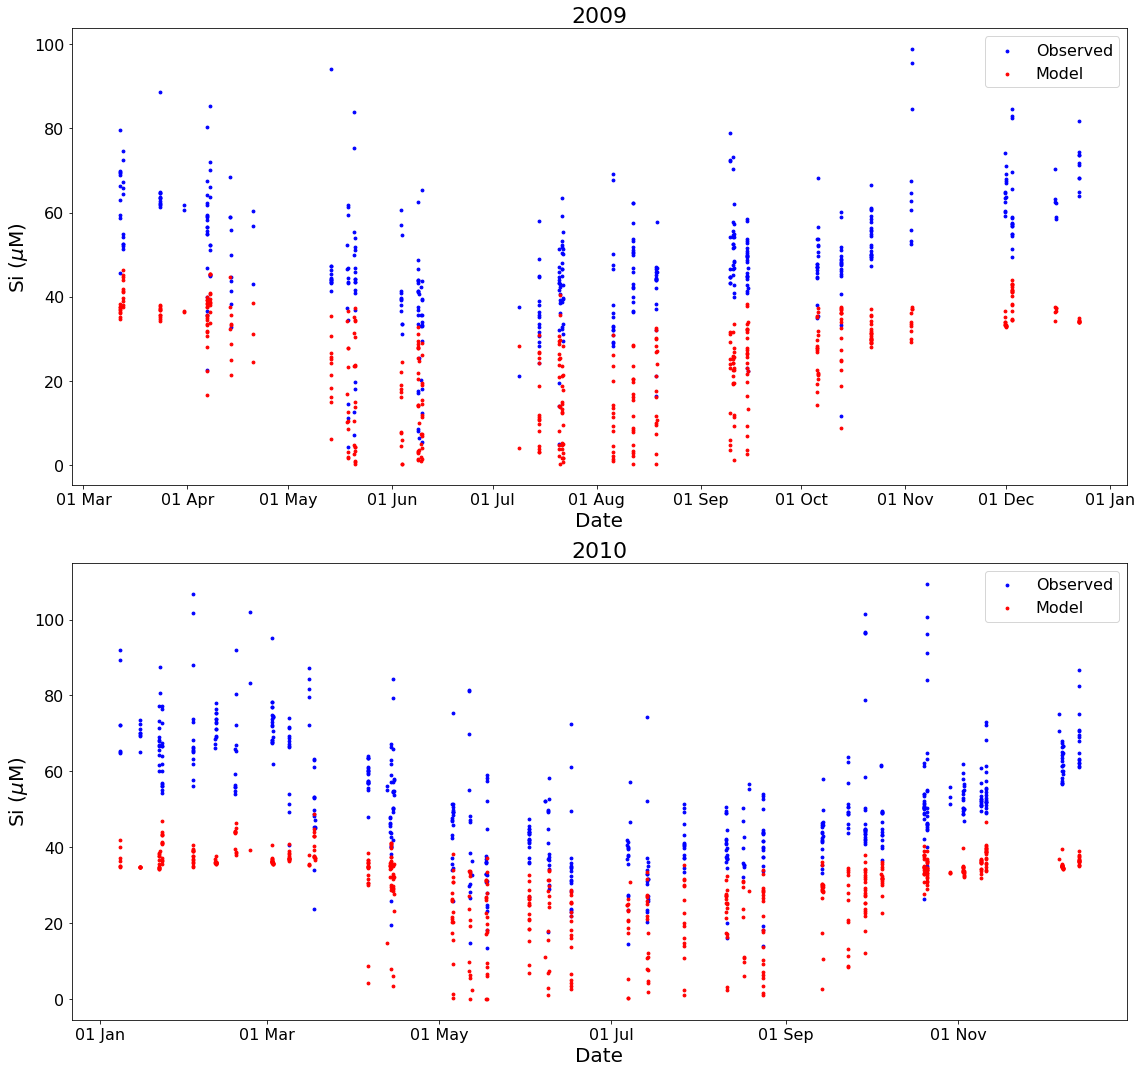

In [13]:
obsvar='Si'
modvar='mod_silicon'

multi_timese_graph(2,(16,15),years,obsvar,modvar)

## Observed Ammonia and model Ammonia over time

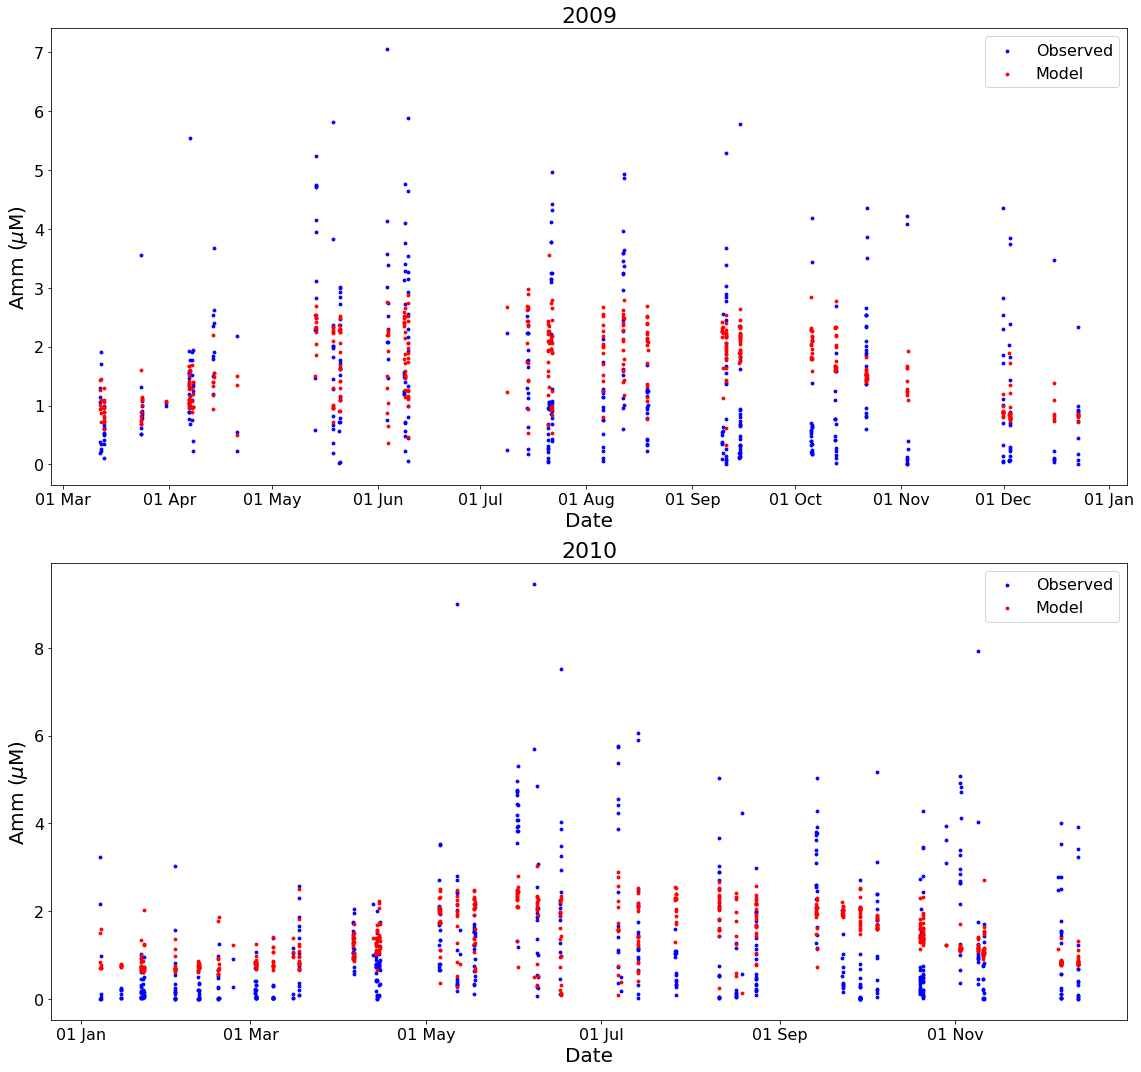

In [14]:
obsvar='Amm'
modvar='mod_ammonium'

multi_timese_graph(2,(16,15),years,obsvar,modvar)

# Error vs time of year

## Nitrate

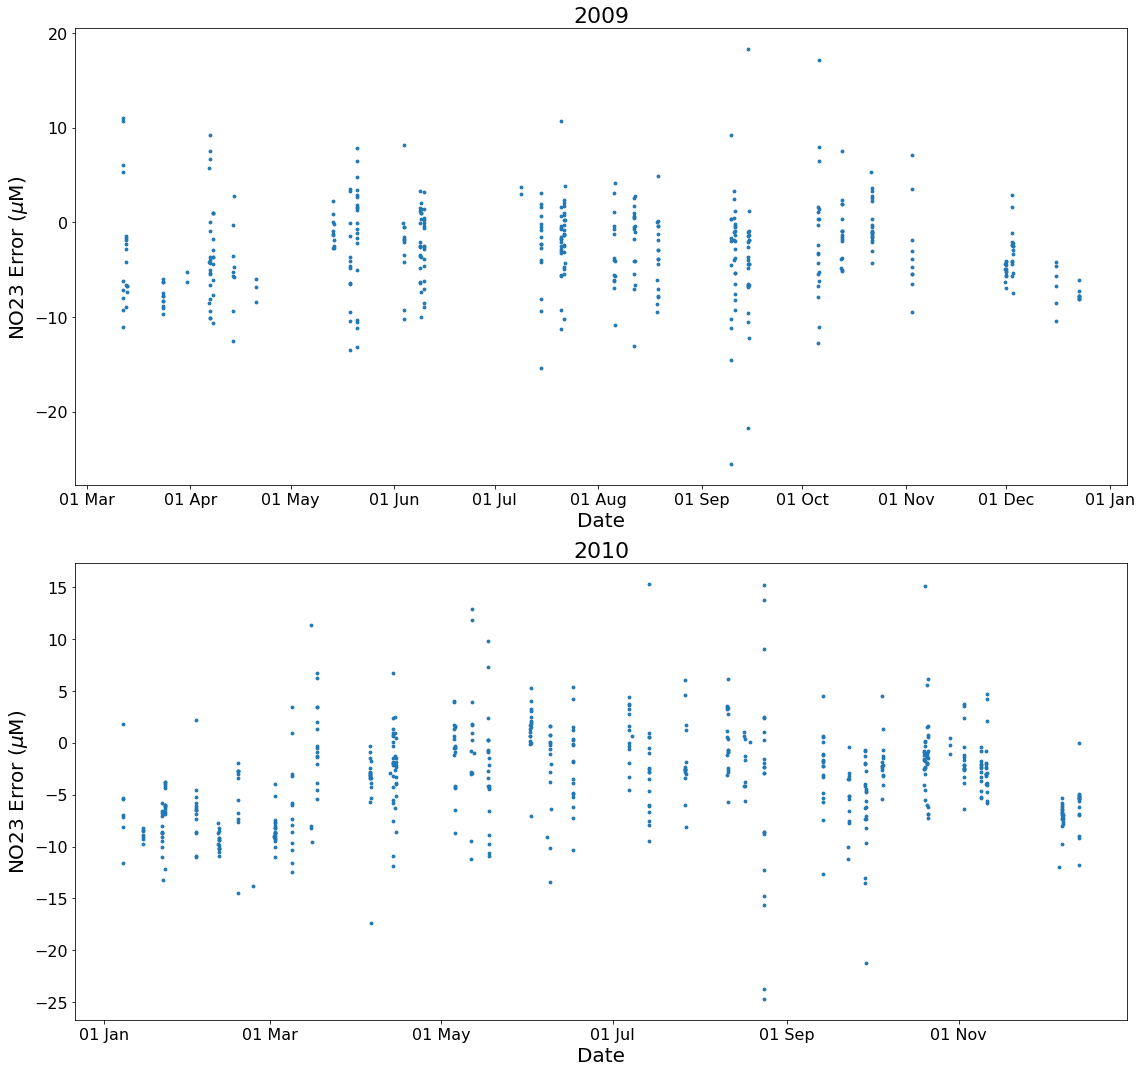

In [15]:
obsvar='NO23'
modvar='mod_nitrate'

multi_timerror_graph(2,(16,15),years,obsvar,modvar)

## Silicon

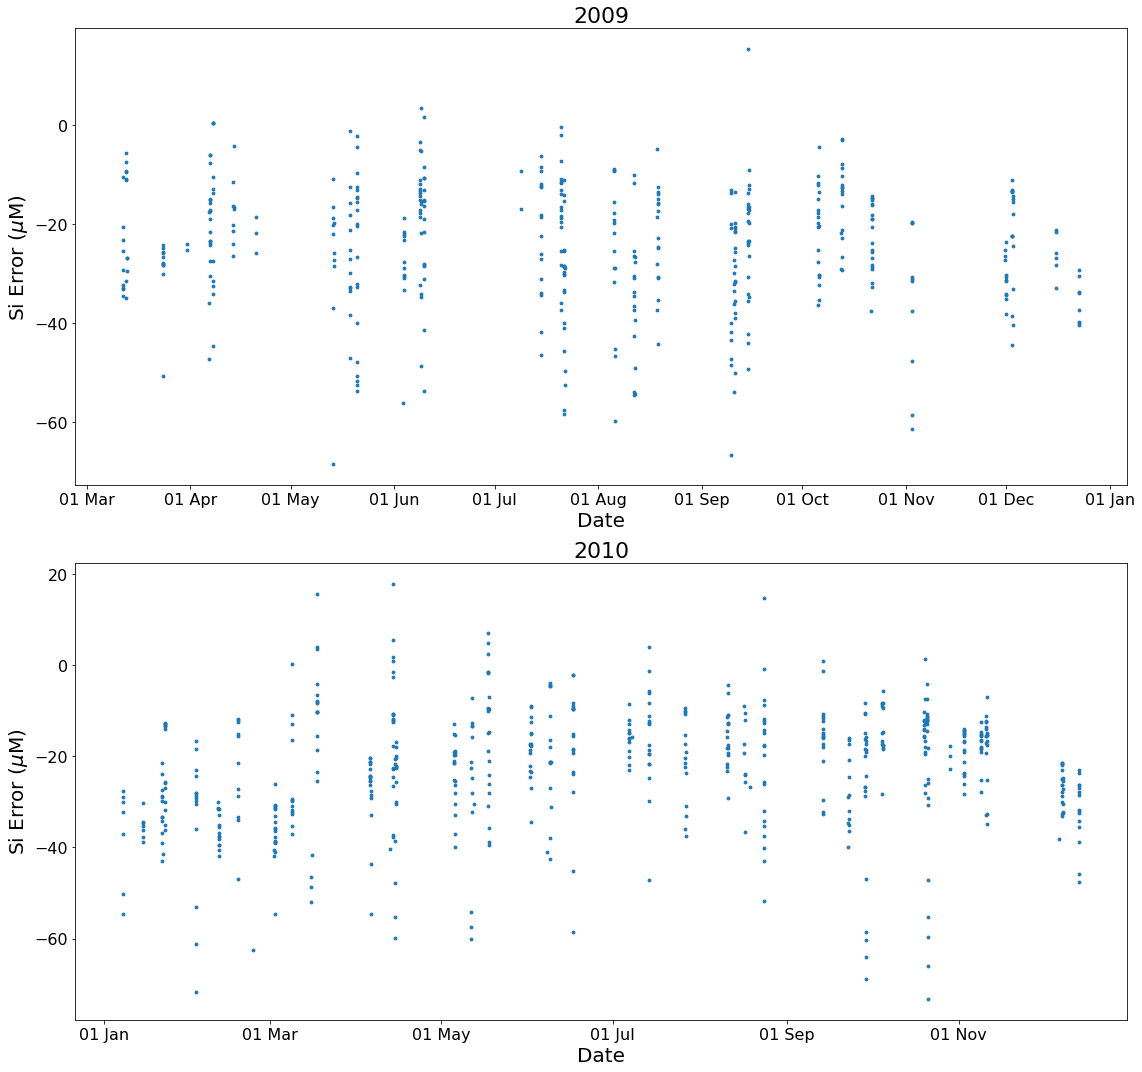

In [16]:
obsvar='Si'
modvar='mod_silicon'

multi_timerror_graph(2,(16,15),years,obsvar,modvar)

## Ammonium

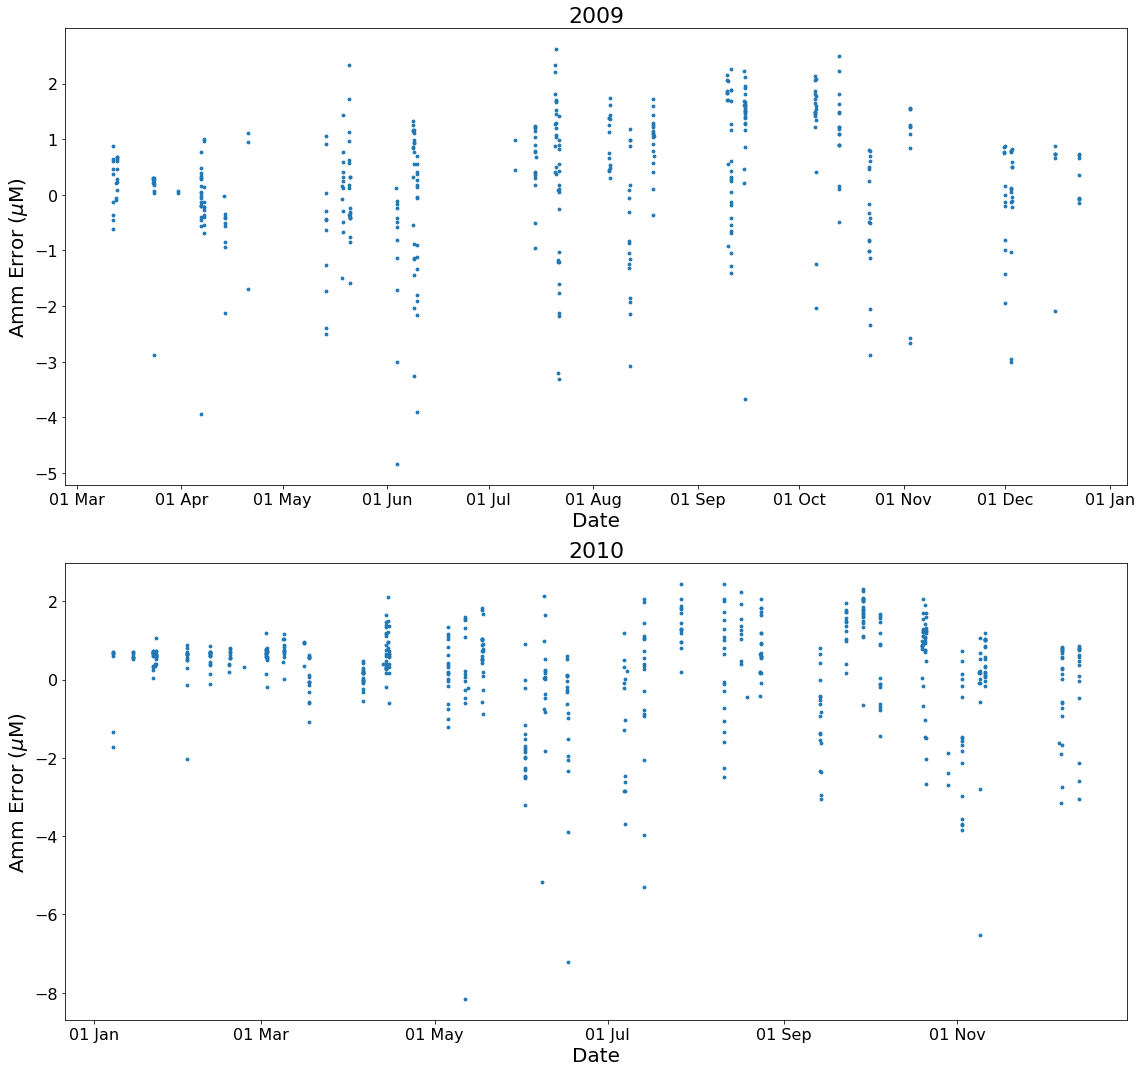

In [17]:
obsvar='Amm'
modvar='mod_ammonium'

multi_timerror_graph(2,(16,15),years,obsvar,modvar)